# Analisi Dati per l'esperienza di Millikan

### Import delle librerie

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use(["science", "grid", "ieee"])

OSError: 'science' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

### Dati pre-misure

In [10]:
# Valori fisici
g = 9.806  # m/s^2
rho_o = 860  # kg/m^3
rho_a = 1.293  # kg/m^3
conv_atm_Pa = 101325  # Pa (from atm)
b = 8.2e-3  # Pa m (costante correzione viscosa)
reticolo = 0.5  # mm

d_isolante = 7.6  # mm

# File Excel
rows = 8
columns = 8
gocce = 12
max_gocce = 3
max_row = 5
max_col = 8

### Funzioni per i conti

In [11]:
def calc_visco(T: float) -> float:
	# T deve essere in celsius
	return (1.8 + 4.765e-3 * (T - 15)) * 1e-5  # N s m^-2


# inutile
def calc_visco_eff(nu: float, press: float, r_0: float) -> float:
	return nu / (1 + b / (press * r_0))


def calc_radius(nu: float, press: float, vel: np.ndarray) -> np.ndarray:
	# ! non sono sicuro che il calcolo del raggio sia corretto
	return np.sqrt(
			(b / (2 * press)) ** 2 + (9 * nu * np.abs(vel)) / (
					2 * g * (rho_o - rho_a))
			) - b / (2 * press)


# ? ma se rho cambia in fz della temperatura, qual'è l'errore che ne viene fuori?


def calc_charge(r: float, v_r: float, E: np.ndarray,
                v_E: np.ndarray) -> np.ndarray:
	return -4 / 3 * np.pi * r ** 3 * (rho_o - rho_a) * g * np.divide(
			(1 + v_E / v_r), E)

### Import dei dati sperimentali

In [12]:
data = pd.read_excel("Dati_Raccolti.xlsx", sheet_name="AllData", header=None)

# print("Dati iniziali:\n", data)

data = (
	data.dropna(axis=1, how="all")  # drop zero column
	.dropna(axis=0, how="all")  # drop zero rows
	.to_numpy()
)

# print("Prima pulizia: ", data)

# split into 2 datasets TP and Vt
TP = data[np.isnan(data[:, 1:]).all(axis=1), 0]
Vt = data[~np.isnan(data[:, 1:]).all(axis=1), :]

# split TP into temperature e pressioni
temperature, pressioni = TP[::2], TP[1::2] * conv_atm_Pa
# split Vt into voltaggi e tempi

voltaggi, tempi = [], []
temp = []
t = np.where(Vt[:, 0] == 0)[0]
for i, row in enumerate(Vt):
	if i in t:
		voltaggi.append(row.tolist())
		if i > 0:
			tempi.append(temp)
			temp = []
	else:
		temp.append(row.tolist())
else:
	tempi.append(temp)

print(tempi, "\n")

voltaggi = np.array(voltaggi)
tempi = np.array(tempi).transpose(0, 2, 1)

print("Temperature [°C]: \n", temperature)
print("Pressioni [Pa]: \n", pressioni)
print("Voltaggi [V/m]: \n", voltaggi)
print("Tempi [s]: \n", tempi)

[[[14.82, 2.98, 4.52, 3.1, 5.13, 3.06, 4.6, 3.01], [17.88, 2.87, 4.83, 2.94, 4.64, 3.04, 4.73, 2.97], [14.05, 3.04, 4.98, 3.09, 4.73, 2.99, 4.62, 3.1], [15.24, 3.08, 4.59, 2.95, 4.76, 3.1, 4.67, 3.05], [16.16, 3.71, 5.18, 3.46, 4.97, 3.2, 4.58, 3.05]], [[10.57, 4.31, 1.85, 1.61, 1.28, 1.36, 1.27, 1.7], [11.93, 4.23, 2.03, 1.97, 1.35, 2.01, 1.28, 1.7], [11.13, 4.22, 2.0, 1.65, 1.42, 1.77, 1.4, 1.81], [11.97, 4.41, 2.09, 1.83, 1.37, 1.8, 1.47, 1.79], [13.45, 4.3, 1.88, 1.83, 1.4, 1.8, 1.45, 1.8]], [[15.47, 4.71, 2.75, 3.47, 2.25, 3.08, 2.35, 3.48], [14.66, 4.74, 2.84, 3.1, 2.1, 3.17, 2.38, 3.25], [16.65, 4.78, 2.88, 3.42, 2.08, 3.44, 2.54, 3.07], [15.77, 4.62, 2.85, 3.4, 2.54, 3.2, 2.32, 3.54], [15.45, 4.86, 2.95, 3.29, 2.47, 3.18, 2.19, 3.43]], [[26.7, 3.93, 2.96, 4.32, 3.26, 4.1, 3.28, 4.12], [27.21, 3.72, 3.05, 3.92, 2.98, 3.65, 3.2, 4.08], [28.4, 4.43, 3.08, 3.69, 3.3, 4.03, 3.3, 3.88], [29.0, 3.67, 2.88, 4.22, 3.46, 3.85, 3.48, 4.25]], [[11.17, 1.73, 1.53, 1.87, 1.45, 1.75, 1.38, 1.

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (9,) + inhomogeneous part.

### Analisi Dati

In [ ]:
def calc_stats(arr: np.ndarray):
	# 2D array
	if arr.ndim == 2:
		return arr.mean(axis=1), arr.std(axis=1, ddof=1)

	# 3D or greater are not implemented
	if arr.ndim > 2:
		raise ValueError("Cannot calculate for arrays with 2 dimensions")

	# 1D array
	return arr.mean(), arr.std(ddof=1)

TypeError: list indices must be integers or slices, not tuple

<Figure size 1980x1500 with 0 Axes>

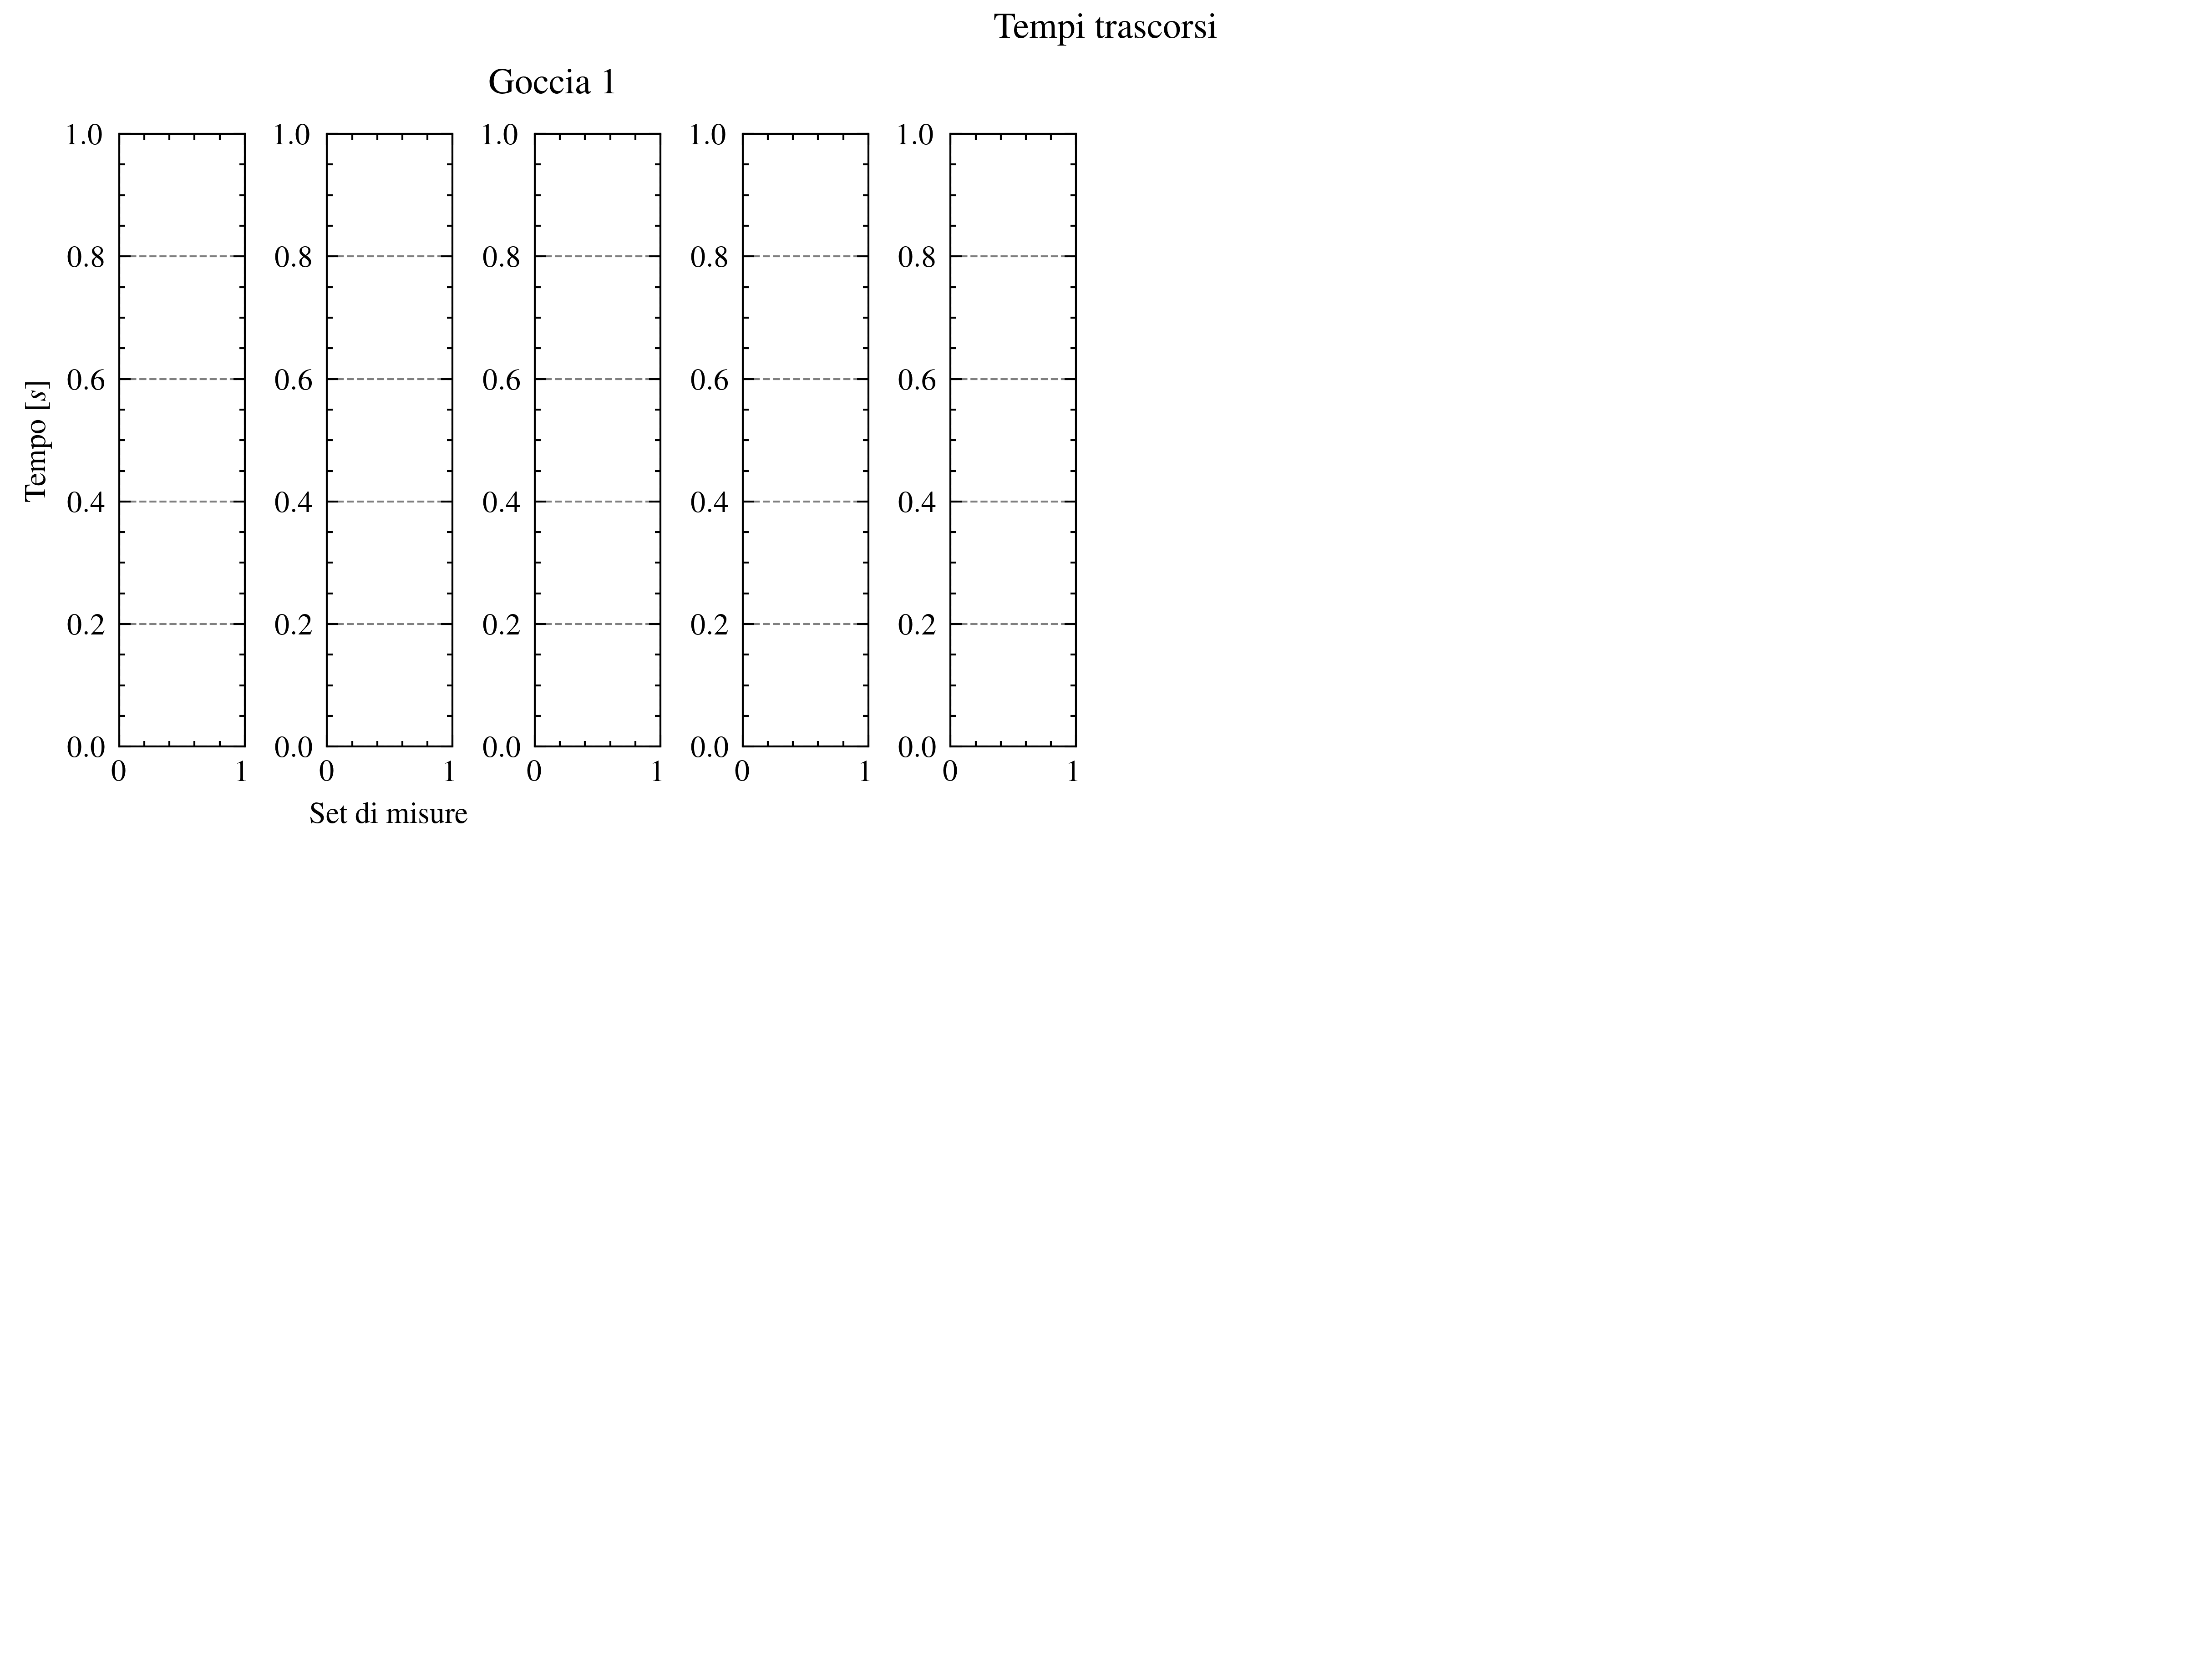

In [ ]:
# Show data collected
plt.tight_layout()
plot_row = np.ceil(np.sqrt(max_gocce)).astype(int)
plot_col = np.ceil(max_gocce / plot_row).astype(int)
fig = plt.figure(constrained_layout=True, figsize=(plot_row * 4, plot_col * 3))
subplots = fig.subfigures(plot_col, plot_row)

plt.suptitle("Tempi trascorsi")
for i in range(max_gocce):
	n, m = i // plot_row, i % plot_row

	axs = subplots[n, m].subplots(1, max_col)
	subplots[n, m].suptitle(f"Goccia {i + 1}")
	axs[1].set_xlabel("Set di misure")
	axs[0].set_ylabel(r"Tempo [$s$]")

	for j in range(max_col):
		axs[j].scatter(j * np.ones(len(tempi[i, j, :max_row])),
		               tempi[i, j, :max_row])

plt.savefig("Images/Tempi trascorsi.svg")
plt.show()

In [ ]:
charges = np.zeros((max_gocce, max_col - 1))

for i in range(0, max_gocce):
	# Tempi
	print(f"~~~~~~~ Goccia {i + 1} ~~~~~~~")
	means_t, stds_t = calc_stats(tempi[i, :max_col, :max_row])
	print(
			f"Tempi e incertezza per set: \n\t"
			+ "\n\t".join(
					f"{a:.4g} ±{b:.2g}s" for a, b in zip(means_t, stds_t))
			)

	# Velocità
	velocità = (reticolo / 1000) / means_t
	print(
			f"Velocità e incertezza per set: \n\t"
			+ "\n\t".join(
					f"{a:.4g} ±{'NOT CALCULATED'}m/s" for a, b in
					zip(velocità, stds_t)
					)
			)

	# Raggio
	nu = calc_visco(temperature[i])  # ? unità di misura
	r = calc_radius(nu, pressioni[i], velocità)
	mean_r, std_r = r.mean(), r.std(ddof=1)

	print(f"nu: {nu:.4g}")
	print(f"Raggio: {mean_r:.4g} ±{std_r:.2g}m")

	# Carica
	E = abs(voltaggi[i, 1:max_col]) / (d_isolante / 1000)
	print(
			f"Campo elettrico per set (2-{max_col}): \n\t"
			+ "\n\t".join(f"{e:.3g} ±{'NOT CALCULATED'} V/m" for e in E)
			)

	q = calc_charge(mean_r, velocità[0], E, velocità[1:])
	print(
			f"Carica e incertezza per set (2-{max_col}): \n\t"
			+ "\n\t".join(f"{a:.4g} ±{'NOT CALCULATED'} C" for a, b in
			              zip(q, stds_t[1:]))
			)
	charges[i] += q

~~~~~~~ Goccia 1 ~~~~~~~
Tempi e incertezza per set: 
	56.94 ±7.5s
	2.544 ±0.26s
	nan ±nans
	nan ±nans
	nan ±nans
	nan ±nans
	nan ±nans
	nan ±nans
Velocità e incertezza per set: 
	8.781e-06 ±NOT CALCULATEDm/s
	0.0001965 ±NOT CALCULATEDm/s
	nan ±NOT CALCULATEDm/s
	nan ±NOT CALCULATEDm/s
	nan ±NOT CALCULATEDm/s
	nan ±NOT CALCULATEDm/s
	nan ±NOT CALCULATEDm/s
	nan ±NOT CALCULATEDm/s
nu: 1.829e-05
Raggio: nan ±nanm
Campo elettrico per set (2-8): 
	4.24e+04 ±NOT CALCULATED V/m
	4.24e+04 ±NOT CALCULATED V/m
	4.24e+04 ±NOT CALCULATED V/m
	nan ±NOT CALCULATED V/m
	nan ±NOT CALCULATED V/m
	nan ±NOT CALCULATED V/m
	nan ±NOT CALCULATED V/m
Carica e incertezza per set (2-8): 
	nan ±NOT CALCULATED C
	nan ±NOT CALCULATED C
	nan ±NOT CALCULATED C
	nan ±NOT CALCULATED C
	nan ±NOT CALCULATED C
	nan ±NOT CALCULATED C
	nan ±NOT CALCULATED C
~~~~~~~ Goccia 2 ~~~~~~~
Tempi e incertezza per set: 
	15.63 ±1.5s
	3.136 ±0.33s
	4.82 ±0.27s
	3.108 ±0.21s
	4.846 ±0.2s
	3.078 ±0.079s
	4.64 ±0.06s
	3.036 ±0.049s
Ve

### Analisi della carica

Carica [C]: nan nan nan nan nan nan nan


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

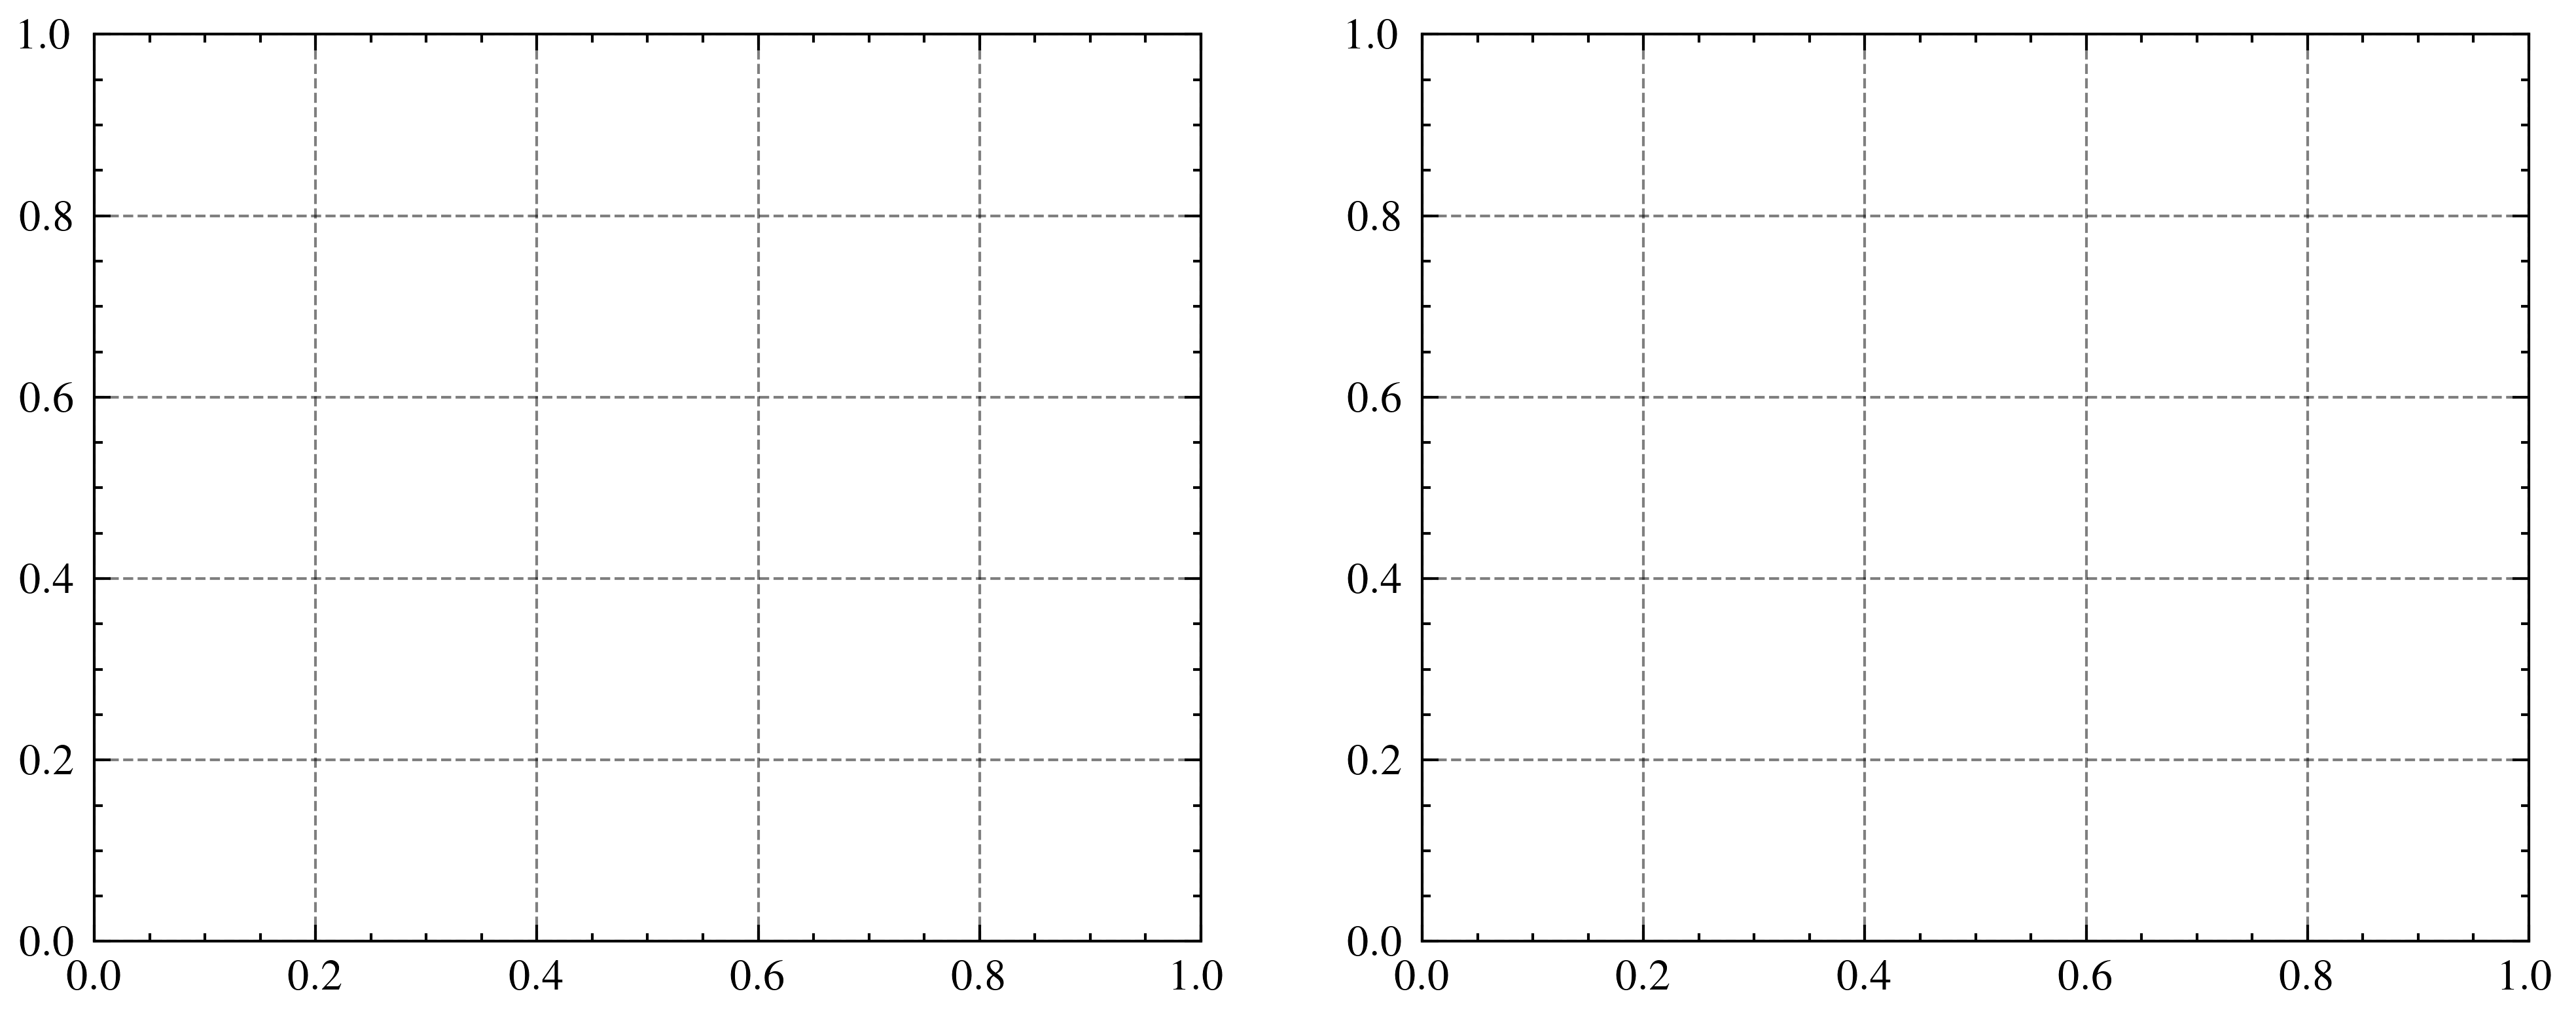

In [ ]:
plot_row = np.ceil(np.sqrt(max_gocce)).astype(int)
plot_col = np.ceil(max_gocce / plot_row).astype(int)
fig, axs = plt.subplots(plot_col, plot_row,
                        figsize=(plot_row * 4, plot_col * 3))

for i in range(max_gocce):
	x = np.linspace(1.5e-19, 1.7e-19, 1000)
	print("Carica [C]: " + " ".join(f"{charge:.3g}" for charge in charges[i]))
	y = sum(np.square(x - charge / np.round(charge / x)) for charge in
	        charges[i])

	n, m = i // plot_row, i % plot_row
	axs[n, m].plot(x, y)

	axs[n, m].set_title(f"Goccia {i + 1}")
	axs[n, m].set_xlabel(r"Carica $q$ [C]")
	axs[n, m].set_ylabel(r"$S(q)$ [C$^2$]")

plt.tight_layout()
plt.suptitle(r"$S(q)$ in funzione di $q$")
plt.savefig("Images/Carica delle gocce.svg")
plt.show()